In [15]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

In [16]:
'''
Read.me

#1. csv파일 읽어오기, x 칼럼 정리 
#2. Pre-processing - Train, Test 데이터를 수정 
                    시간추가, 
                    누적데이터를 10분간의 데이터로 변경, 
                    풍향을 16방위로 변경, 
                    고장난 센서 삭제 
                    
#3. X변수들을 산술평균, 가중평균으로 계산
                    - 변수를 9개로 압축하면, 오히려 mse값이 증가하는 문제가 있음
                      일단 전체 X를 사용하도록, 주석처리 해놨음
                      
#4. 데이터를 120분씩 묶는 함수 (0~120, 10~130 ...)
#5. X를 모두 이용한 train_df 생성, 데이터 정규화, 지정한 Y만큼 데이터 늘리기
#6. X를 모두 이용한 test_df 생성, 정규화 
#7. 모델 생성
#8. 모델 학습 
#9. 마지막 3일 데이터('Y18')를 사용하여 fine-tuning
#10. 결과 예측하기 

'''

"\nRead.me\n\n#1. csv파일 읽어오기, x 칼럼 정리 \n#2. Pre-processing - Train, Test 데이터를 수정 \n                    시간추가, \n                    누적데이터를 10분간의 데이터로 변경, \n                    풍향을 16방위로 변경, \n                    고장난 센서 삭제 \n                    \n#3. X변수들을 산술평균, 가중평균으로 계산\n                    - 변수를 9개로 압축하면, 오히려 mse값이 증가하는 문제가 있음\n                      일단 전체 X를 사용하도록, 주석처리 해놨음\n                      \n#4. 데이터를 120분씩 묶는 함수 (0~120, 10~130 ...)\n#5. X를 모두 이용한 train_df 생성, 데이터 정규화, 지정한 Y만큼 데이터 늘리기\n#6. X를 모두 이용한 test_df 생성, 정규화 \n#7. 모델 생성\n#8. 모델 학습 \n#9. 마지막 3일 데이터('Y18')를 사용하여 fine-tuning\n#10. 결과 예측하기 \n\n"

In [17]:
#1
#csv파일 불러오기

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
    
#x칼럼 정리.
x_time = ['id'] #시간
x_temperature = ['X00', 'X07', 'X28', 'X31', 'X32'] #기온
x_local_pressure = ['X01', 'X06', 'X22', 'X27', 'X29'] #현지기압
x_wind_speed = ['X02', 'X03', 'X18', 'X24', 'X26'] #풍속
x_daily_rainfall = ['X04', 'X10', 'X21', 'X36', 'X39'] #일일 누적강수량
x_sealevel_pressure = ['X05', 'X08', 'X09', 'X23', 'X33'] #해면기압
x_daily_sun = ['X11', 'X34'] #일일 누적일사량 (X14, X16, X19는 제거됨, 결측치)
x_humidity = ['X12', 'X20', 'X30', 'X37', 'X38'] #습도
x_wind_direction = ['X13', 'X15', 'X17', 'X25', 'X35'] #풍향
x_pressure = ['X01', 'X06', 'X22', 'X27', 'X29', 'X05', 'X08', 'X09', 'X23', 'X33']

#y칼럼 정리
y_sensor = ['Y00', 'Y01','Y02','Y03','Y04', 'Y05', 'Y06', 'Y07', 'Y08', 
            'Y09', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17'] #센서측정온도
y_target = ['Y18'] #예측대상

In [18]:
"""
#2 pre-processing(1)

시간 직선 변경, 시간 cos 변환, 누적데이터를 10분간의 데이터로 변경, 풍향을 cos 변환, 풍향을 16방위로 변경, 고장난 센서 삭제

"""

#id값들을 시간형 데이터로 변경 (y=x)
def make_timedata(df):
    minute = (df['id'] % 144).astype(int)
    df['id'] = minute
    print("id를 y=x로 변경 완료")
    
#id값들을 시간형 데이터로 변경하는 함수 생성
def make_timedata1(df):
    minute = (df['id'] % 144).astype(int)
    min_in_day = 24*6

    df['id'] = np.cos(np.pi * minute / min_in_day)
    print("id를 cos데이터로 변경 완료")
    
# 누적강수량/누적일사량을 10분 단위로 변환    
def accumulate_to_10minute(df, col):
    for i in col:
        #누적데이터를 10분간의 데이터로 분류
        tmp = df[i].iloc[0]
        df[i] = df[i] - df[i].shift(1)
        df[i].iloc[0] = tmp
        
        #24시를 넘어서 데이터가 음수가 된다면, 0으로 변경
        for j in np.arange(0,len(df[i])):
            if df[i].iloc[j] < 0:
                df[i].iloc[j] = 0   
    print("누적 데이터 변경 완료")
     
#풍향을 cos 변환
def make_wind_direction(df):
    df['X13'] = np.cos(df['X13'] * np.pi /360)
    df['X15'] = np.cos(df['X15'] * np.pi /360)
    df['X17'] = np.cos(df['X17'] * np.pi /360)
    df['X25'] = np.cos(df['X25'] * np.pi /360)
    df['X35'] = np.cos(df['X35'] * np.pi /360)
    print('풍향을 cos데이터로 변경 완료')
    
    
#풍향을 16방위로 변경
def make_wind_direction1(df):
    df['X13'] = (df['X13'] + 22.5 * 0.5) // 22.5
    df['X15'] = (df['X15'] + 22.5 * 0.5) // 22.5
    df['X17'] = (df['X17'] + 22.5 * 0.5) // 22.5
    df['X25'] = (df['X25'] + 22.5 * 0.5) // 22.5
    df['X35'] = (df['X35'] + 22.5 * 0.5) // 22.5
    print('풍향을 16등분 완료')

#고장난 센서 X14, X16, X19 삭제
train = train.drop(['X14', 'X16', 'X19'], axis =1)
test = test.drop(['X14', 'X16', 'X19'], axis =1)
print('X14, X16, X19 삭제 완료')

#시간 생성
make_timedata(train)
make_timedata(test)

#누적 강수량 변경
accumulate_to_10minute(train, x_daily_rainfall)
accumulate_to_10minute(test, x_daily_rainfall)

#누적 일사량 변경
accumulate_to_10minute(train, x_daily_sun)
accumulate_to_10minute(test, x_daily_sun)

#wind_direction을 16방위 데이터로 변경
make_wind_direction(train)
make_wind_direction(test)    

X14, X16, X19 삭제 완료
id를 y=x로 변경 완료
id를 y=x로 변경 완료
누적 데이터 변경 완료
누적 데이터 변경 완료
누적 데이터 변경 완료
누적 데이터 변경 완료
풍향을 cos데이터로 변경 완료
풍향을 cos데이터로 변경 완료


In [19]:
#3 x변수들을 평균 값들로 변경하는 부분. (산술평균, 가중평균)

"""
변수는 총 9개

변경X - 시간, 풍향
산술평균 - 기온, 강수량, 일사량
가중평균 - 해면기압, 지면기압, 풍속, 습도

"""
# Train의 산술평균 (기온, 강수량, 일사량)
def make_train_avg(df, col_name, col_num=[]):
    df[col_name] = pd.Series(train[col_num].mean(axis = 1))
    
    
# Train의 가중평균 (해면기압, 지면기압, 풍속, 습도)
def make_train_w_avg(df, col_name, col_num=[]):
    mat = pd.concat([train.loc[:4319,col_num], train.loc[:4319,y_sensor]], axis=1)
    cor_matrix = mat.corr().iloc[5:,:5]
    cor = pd.DataFrame(np.abs(cor_matrix).sum())
    cor_sum = pd.DataFrame(cor.sum(axis=0))
    weight = pd.Series()
    weighted_mean = []
    
    for i in col_num:
        weight[i] = (cor.loc[i]/cor_sum).values
    for j in np.arange(len(train["X12"])):
        weighted_mean.append(np.average(train.loc[j, col_num], 
                                        weights = weight.values, axis=0)[0][0])

    df[col_name] = pd.Series(weighted_mean)
    print(df)
    print("가중평균 변환 완료")  

    
# Test의 산술평균 (기온, 강수량, 일사량)
def make_test_avg(df, col_name, col_num=[]):
    df[col_name] = pd.Series(test[col_num].mean(axis = 1))
    
    
# Test의 가중평균 (해면기압, 지면기압, 풍속, 습도)
def make_test_w_avg(df, col_name, col_num=[]):
    mat = pd.concat([train.loc[:,col_num], train.loc[:,y_sensor]], axis=1)
    cor_matrix = mat.corr().iloc[5:,:5]
    cor = pd.DataFrame(np.abs(cor_matrix).sum())
    cor_sum = pd.DataFrame(cor.sum(axis=0))
    weight = pd.Series()
    weighted_mean = []
    
    for i in col_num:
        weight[i] = (cor.loc[i]/cor_sum).values
    for j in np.arange(len(test["X12"])):
        weighted_mean.append(np.average(test.loc[j, col_num],
                                        weights = weight.values, axis=0)[0][0])

    df[col_name] = pd.Series(weighted_mean)
    print(df)
    print("가중평균 변환 완료")  
    
"""
#학습용 데이터프레임 생성
train_df = pd.DataFrame()


#X 대표값 추가
make_train_avg(train_df, 'x_temperature', x_temperature)
make_train_w_avg(train_df, 'x_local_pressure', x_local_pressure)
make_train_w_avg(train_df, 'x_wind_speed', x_wind_speed)
make_train_avg(train_df, 'x_daily_rainfall', x_daily_rainfall)
make_train_w_avg(train_df, 'x_sealevel_pressure', x_sealevel_pressure)
make_train_avg(train_df, 'x_daily_sun', x_daily_sun)
make_train_w_avg(train_df, 'x_humidity', x_humidity)

#풍향도 일단 산술평균
make_train_avg(train_df, 'x_wind_direction', x_wind_direction)



# standardization을 위해 평균과 표준편차 구하기
MEAN = train_df.mean()
STD = train_df.std()

# 표준편차가 0일 경우 대비하여 1e-07 추가 
train_df = (train_df - MEAN) / (STD + 1e-07)

#id값을 추가
train_df.insert(loc=0, column='id', value=train['id'])

train_df
"""

"""
# 테스트용 데이터프레임 생성
test_df = pd.DataFrame()

#X 대표값 추가
make_test_avg(test_df, 'x_temperature', x_temperature)
make_test_w_avg(test_df, 'x_local_pressure', x_local_pressure)
make_test_w_avg(test_df, 'x_wind_speed', x_wind_speed)
make_test_avg(test_df, 'x_daily_rainfall', x_daily_rainfall)
make_test_w_avg(test_df, 'x_sealevel_pressure', x_sealevel_pressure)
make_test_avg(test_df, 'x_daily_sun', x_daily_sun)
make_test_w_avg(test_df, 'x_humidity', x_humidity)

#풍향도 일단 산술평균
make_test_avg(test_df, 'x_wind_direction', x_wind_direction)

test_df = (test_df - MEAN) / (STD + 1e-07)

#id값 추가
test_df.insert(loc=0, column='id', value=test['id'])

test_df
"""

"\n# 테스트용 데이터프레임 생성\ntest_df = pd.DataFrame()\n\n#X 대표값 추가\nmake_test_avg(test_df, 'x_temperature', x_temperature)\nmake_test_w_avg(test_df, 'x_local_pressure', x_local_pressure)\nmake_test_w_avg(test_df, 'x_wind_speed', x_wind_speed)\nmake_test_avg(test_df, 'x_daily_rainfall', x_daily_rainfall)\nmake_test_w_avg(test_df, 'x_sealevel_pressure', x_sealevel_pressure)\nmake_test_avg(test_df, 'x_daily_sun', x_daily_sun)\nmake_test_w_avg(test_df, 'x_humidity', x_humidity)\n\n#풍향도 일단 산술평균\nmake_test_avg(test_df, 'x_wind_direction', x_wind_direction)\n\ntest_df = (test_df - MEAN) / (STD + 1e-07)\n\n#id값 추가\ntest_df.insert(loc=0, column='id', value=test['id'])\n\ntest_df\n"

In [20]:
#학습용 데이터프레임 생성

train_df = pd.DataFrame(pd.concat([train[x_temperature], 
                                  train[x_daily_sun]], axis=1))

test_df = pd.DataFrame(pd.concat([test[x_temperature], 
                                 test[x_daily_sun]], axis=1))

train_df
# 온도와 일사량만을 사용한 예측 정확도가 가장 높다는 것을 확인하여 X 변수를 수정

,X00,X07,X28,X31,X32,X11,X34
0,9.7,12.2,12.3,8.2,10.7,0.0,0.0
1,9.3,12.1,12.1,8.3,10.3,0.0,0.0
2,9.4,12.1,12.1,8.0,9.7,0.0,0.0
3,9.4,12.0,12.1,7.7,9.4,0.0,0.0
4,9.2,12.0,12.0,7.4,9.4,0.0,0.0
...,...,...,...,...,...,...,...
4747,19.9,21.7,23.8,17.7,19.1,0.0,0.0
4748,19.9,21.6,23.6,17.7,19.2,0.0,0.0
4749,19.7,21.4,23.6,17.8,19.2,0.0,0.0
4750,19.4,21.3,23.3,17.7,19.3,0.0,0.0


In [21]:
MEAN = train_df.mean()
STD = train_df.std()

# 표준편차가 0일 경우 대비하여 1e-07 추가 
train_df = (train_df - MEAN) / (STD + 1e-07)
test_df = (test_df - MEAN) / (STD + 1e-07)

In [22]:
def remove_outlier(df):
    for j in list(df.columns):
        for i in np.arange(0,len(df["X00"])):
            if df.loc[i,j] > 3:
                df.loc[i,j] = df.shift(1).loc[i,j]

In [23]:
remove_outlier(train_df)

In [24]:
remove_outlier(test_df)

In [25]:
train_df

,X00,X07,X28,X31,X32,X11,X34
0,-2.236377,-2.160752,-2.314454,-2.109779,-1.766623,-0.794399,-0.762928
1,-2.321347,-2.183598,-2.361789,-2.091664,-1.842501,-0.794399,-0.762928
2,-2.300105,-2.183598,-2.361789,-2.146009,-1.956318,-0.794399,-0.762928
3,-2.300105,-2.206443,-2.361789,-2.200355,-2.013226,-0.794399,-0.762928
4,-2.342589,-2.206443,-2.385457,-2.254700,-2.013226,-0.794399,-0.762928
...,...,...,...,...,...,...,...
4747,-0.069655,0.009577,0.407308,-0.388845,-0.173188,-0.794399,-0.762928
4748,-0.069655,-0.013269,0.359973,-0.388845,-0.154219,-0.794399,-0.762928
4749,-0.112139,-0.058960,0.359973,-0.370730,-0.154219,-0.794399,-0.762928
4750,-0.175867,-0.081806,0.288971,-0.388845,-0.135249,-0.794399,-0.762928


#학습용 데이터프레임 생성

train_df = pd.DataFrame()

make_train_avg(train_df, 'x_temperature', x_temperature)
make_train_avg(train_df, 'x_wind_speed', x_wind_speed)
make_train_avg(train_df, 'x_daily_rainfall', x_daily_rainfall)
make_train_avg(train_df, 'x_daily_sun', x_daily_sun)
make_train_avg(train_df, 'x_humidity', x_humidity)
make_train_avg(train_df, 'x_wind_direction', x_wind_direction)
make_train_avg(train_df, 'x_local_pressure', x_local_pressure)
make_train_avg(train_df, 'x_sealevel_pressure', x_sealevel_pressure)

train_df.insert(loc=0, column='id', value=train['id'])

MEAN = train_df.mean()
STD = train_df.std()

# 표준편차가 0일 경우 대비하여 1e-07 추가 
train_df = (train_df - MEAN) / (STD + 1e-07)


# 테스트용 데이터프레임 생성
test_df = pd.DataFrame()

#X 대표값 추가
make_test_avg(test_df, 'x_temperature', x_temperature)
make_test_avg(test_df, 'x_wind_speed', x_wind_speed)
make_test_avg(test_df, 'x_daily_rainfall', x_daily_rainfall)
make_test_avg(test_df, 'x_daily_sun', x_daily_sun)
make_test_avg(test_df, 'x_humidity', x_humidity)
make_test_avg(test_df, 'x_local_pressure', x_local_pressure)
make_test_avg(test_df, 'x_sealevel_pressure', x_sealevel_pressure)
make_test_avg(test_df, 'x_wind_direction', x_wind_direction)

#id값 추가
test_df.insert(loc=0, column='id', value=test['id'])

#풍향도 일단 산술평균

test_df = (test_df - MEAN) / (STD + 1e-07)

test_df

In [26]:
#4. RNN 모델에 입력 할 수 있는 시계열 형태로 데이터 변환 
def convert_to_timeseries(df, interval):
    sequence_list = []
    target_list = []
    
    for i in tqdm(range(df.shape[0] - interval)):
        sequence_list.append(np.array(df.iloc[i:i+interval,:-1]))
        target_list.append(df.iloc[i+interval,-1])
    
    sequence = np.array(sequence_list)
    target = np.array(target_list)
    
    return sequence, target

In [27]:
#5. 전체 데이터를 사용하는 경우.

"""

train_df 생성

"""

#x변수의 개수 설정
x_num = 7


#학습에 사용할 Y값 지정
y_columns = ['Y09', 'Y16', 'Y15']


#지정한 Y들만큼 데이터의 길이를 늘림
sequence = np.empty((0,12, x_num))
target = np.empty((0,))

for column in y_columns :
    
    concat = pd.concat([train_df, train[column]], axis = 1)

    _sequence, _target = convert_to_timeseries(concat.head(144*30), interval = 12)

    sequence = np.vstack((sequence, _sequence))
    target = np.hstack((target, _target))

100%|██████████| 4308/4308 [00:00<00:00, 4500.18it/s]


In [28]:
"""
#6. test_df 생성 (x변수를 모두 사용)
"""

train_df['dummy'] = 0
test_df['dummy'] = 0

X_test, _ = convert_to_timeseries(pd.concat([train_df, test_df], axis = 0), interval=12)
X_test = X_test[-11520:, :, :]

# 만들어 두었던 dummy feature 제거
train_df.drop('dummy', axis = 1, inplace = True)
test_df.drop('dummy', axis = 1, inplace = True)

100%|██████████| 16260/16260 [00:08<00:00, 1903.64it/s]


In [29]:
"""

#7. 학습 모델 생성

"""

simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=sequence.shape[-2:]),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mse')
simple_lstm_model.summary()


# loss가 4미만으로 떨어지면 학습 종료 시키는 기능
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if(logs.get('loss') < 4):
            print('\n Loss is under 4, cancelling training')
            self.model.stop_training = True
            

callbacks = myCallback()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               69632     
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 135,681
Trainable params: 135,681
Non-trainable params: 0
_________________________________________________________________


In [30]:
"""
#8. 모델 학습
"""


simple_lstm_model.fit(    
    sequence, target,
    epochs=60,
    batch_size=64,
    verbose=1,
    shuffle=False,
    callbacks = [callbacks]
)

Epoch 1/60
202/202 [==============================] - 1s 3ms/step - loss: 61.7780
Epoch 2/60
202/202 [==============================] - 1s 3ms/step - loss: 5.8222
Epoch 3/60
202/202 [==============================] - 1s 3ms/step - loss: 4.3660
Epoch 4/60
202/202 [==============================] - 1s 3ms/step - loss: 4.2428
Epoch 5/60
199/202 [============================>.] - ETA: 0s - loss: 3.9314
 Loss is under 4, cancelling training
202/202 [==============================] - 1s 3ms/step - loss: 3.9062


In [31]:
"""

#9. 마지막 3일 데이터('Y18')를 사용하여 fine-tuning 

"""

simple_lstm_model.layers[0].trainable = False
finetune_X, finetune_y = convert_to_timeseries(pd.concat([train_df.tail(432), train['Y18'].tail(432)], axis = 1), interval=12)


finetune_history = simple_lstm_model.fit(
            finetune_X, finetune_y,
            epochs=32,
            batch_size=64,
            shuffle=False,
            verbose = 1)

100%|██████████| 420/420 [00:00<00:00, 2634.87it/s]

Epoch 1/32
1/7 [===>..........................] - ETA: 0s - loss: 8.8999

7/7 [==============================] - 0s 3ms/step - loss: 7.2506
Epoch 2/32
7/7 [==============================] - 0s 3ms/step - loss: 7.5667
Epoch 3/32
7/7 [==============================] - 0s 3ms/step - loss: 6.1004
Epoch 4/32
7/7 [==============================] - 0s 3ms/step - loss: 4.2792
Epoch 5/32
7/7 [==============================] - 0s 3ms/step - loss: 5.0687
Epoch 6/32
7/7 [==============================] - 0s 3ms/step - loss: 4.6252
Epoch 7/32
7/7 [==============================] - 0s 3ms/step - loss: 4.5571
Epoch 8/32
7/7 [==============================] - 0s 3ms/step - loss: 4.5435
Epoch 9/32
7/7 [==============================] - 0s 3ms/step - loss: 5.1535
Epoch 10/32
7/7 [==============================] - 0s 3ms/step - loss: 4.2614
Epoch 11/32
7/7 [==============================] - 0s 3ms/step - loss: 4.6569
Epoch 12/32
7/7 [==============================] - 0s 3ms/step - loss: 4.2467
Epoch 13/32
7/7 [==============================] - 0s 3ms/step - loss: 4.2631
Epoch 

In [32]:
#10. 결과 예측하기 
finetune_pred = simple_lstm_model.predict(X_test)


# 제출 파일 만들기
submit = pd.DataFrame({'id':range(144*33, 144*113),
              'Y18':finetune_pred.reshape(1,-1)[0]})

submit.to_csv('submit.csv', index = False)

# PCA

### X 변수들을 차원축소하여 예측한 결과는 좋지 않았음

In [22]:
X_train = train.iloc[:, :38]
X_train #풍향 cos 변환하고 모든 col

,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,...,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
0,0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,...,69.1,8.2,10.7,1010.1,0.0,-0.618408,0.0,77.2,62.6,0.0
1,1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,...,70.3,8.3,10.3,1010.1,0.0,-0.304033,0.0,77.3,63.5,0.0
2,2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,...,71.5,8.0,9.7,1010.0,0.0,-0.463296,0.0,77.3,63.9,0.0
3,3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,...,73.2,7.7,9.4,1010.1,0.0,-0.292372,0.0,77.5,64.5,0.0
4,4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,...,74.3,7.4,9.4,1010.1,0.0,0.044491,0.0,78.0,65.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,139,19.9,987.6,0.9,0.8,0.0,1006.9,987.7,21.7,1007.5,...,89.9,17.7,19.1,1007.5,0.0,-0.330514,0.0,82.3,58.6,0.0
4748,140,19.9,987.6,0.5,0.7,0.0,1006.8,987.7,21.6,1007.5,...,91.3,17.7,19.2,1007.5,0.0,0.159020,0.0,82.5,59.1,0.0
4749,141,19.7,987.7,0.9,0.6,0.0,1006.9,987.6,21.4,1007.4,...,90.2,17.8,19.2,1007.5,0.0,-0.603208,0.0,83.0,58.9,0.0
4750,142,19.4,987.7,0.9,0.8,0.0,1006.9,987.8,21.3,1007.6,...,90.1,17.7,19.3,1007.6,0.0,-0.866025,0.0,83.2,59.8,0.0


In [48]:
X_train1 = train.iloc[:, 1:38]
X_train1 #풍향 cos 변환하고 id 제외

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,...,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,1009.8,...,69.1,8.2,10.7,1010.1,0.0,-0.618408,0.0,77.2,62.6,0.0
1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,1009.9,...,70.3,8.3,10.3,1010.1,0.0,-0.304033,0.0,77.3,63.5,0.0
2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,1010.1,...,71.5,8.0,9.7,1010.0,0.0,-0.463296,0.0,77.3,63.9,0.0
3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,1010.0,...,73.2,7.7,9.4,1010.1,0.0,-0.292372,0.0,77.5,64.5,0.0
4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,1010.0,...,74.3,7.4,9.4,1010.1,0.0,0.044491,0.0,78.0,65.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,19.9,987.6,0.9,0.8,0.0,1006.9,987.7,21.7,1007.5,1007.4,...,89.9,17.7,19.1,1007.5,0.0,-0.330514,0.0,82.3,58.6,0.0
4748,19.9,987.6,0.5,0.7,0.0,1006.8,987.7,21.6,1007.5,1007.4,...,91.3,17.7,19.2,1007.5,0.0,0.159020,0.0,82.5,59.1,0.0
4749,19.7,987.7,0.9,0.6,0.0,1006.9,987.6,21.4,1007.4,1007.5,...,90.2,17.8,19.2,1007.5,0.0,-0.603208,0.0,83.0,58.9,0.0
4750,19.4,987.7,0.9,0.8,0.0,1006.9,987.8,21.3,1007.6,1007.5,...,90.1,17.7,19.3,1007.6,0.0,-0.866025,0.0,83.2,59.8,0.0


In [61]:
X_train2 = train.iloc[:, 1:38]
X_train2 #풍향 16등분하고 모든 col

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,...,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,1009.8,...,69.1,8.2,10.7,1010.1,0.0,11.0,0.0,77.2,62.6,0.0
1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,1009.9,...,70.3,8.3,10.3,1010.1,0.0,10.0,0.0,77.3,63.5,0.0
2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,1010.1,...,71.5,8.0,9.7,1010.0,0.0,10.0,0.0,77.3,63.9,0.0
3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,1010.0,...,73.2,7.7,9.4,1010.1,0.0,10.0,0.0,77.5,64.5,0.0
4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,1010.0,...,74.3,7.4,9.4,1010.1,0.0,8.0,0.0,78.0,65.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,19.9,987.6,0.9,0.8,0.0,1006.9,987.7,21.7,1007.5,1007.4,...,89.9,17.7,19.1,1007.5,0.0,10.0,0.0,82.3,58.6,0.0
4748,19.9,987.6,0.5,0.7,0.0,1006.8,987.7,21.6,1007.5,1007.4,...,91.3,17.7,19.2,1007.5,0.0,7.0,0.0,82.5,59.1,0.0
4749,19.7,987.7,0.9,0.6,0.0,1006.9,987.6,21.4,1007.4,1007.5,...,90.2,17.8,19.2,1007.5,0.0,11.0,0.0,83.0,58.9,0.0
4750,19.4,987.7,0.9,0.8,0.0,1006.9,987.8,21.3,1007.6,1007.5,...,90.1,17.7,19.3,1007.6,0.0,13.0,0.0,83.2,59.8,0.0


In [167]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [168]:
chi_square_value,p_value=calculate_bartlett_sphericity(train_df)
chi_square_value, p_value

(71163.80627919428, 0.0)

In [169]:
kmo_all,kmo_model=calculate_kmo(train_df)
kmo_model

0.8550988190083817

In [170]:
fa = FactorAnalyzer()
fa.fit(train_df)
ev, v = fa.get_eigenvalues()

In [171]:
ev

array([5.80335713, 0.9815599 , 0.0779585 , 0.06138336, 0.04159537,
       0.02134151, 0.01280424])

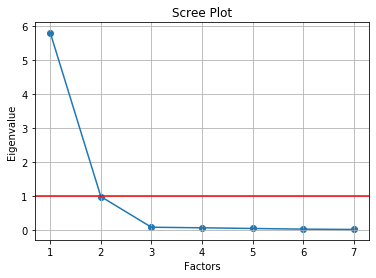

In [172]:
plt.scatter(range(1,train_df.shape[1]+1),ev)
plt.plot(range(1,train_df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.axhline(1, color = 'r')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [173]:
ev[ev>1]

array([5.80335713])

In [178]:
fa = FactorAnalyzer(rotation = 'varimax', n_factors = 2)
fa.fit(train_df)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=2, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [179]:
pd.DataFrame(fa.get_factor_variance(), index = ['SS_loadings', 'Proportion Var', 'Cumulative Var'])

,0,1
SS_loadings,4.463967,2.222778
Proportion Var,0.637710,0.317540
Cumulative Var,0.637710,0.955249


In [180]:
train_pca = pd.DataFrame(fa.fit_transform(train_df), columns = ['X1', 'X2'])
train_pca

,X1,X2
0,-2.220411,-0.066332
1,-2.261994,-0.062276
2,-2.291390,-0.062358
3,-2.327908,-0.050953
4,-2.345622,-0.049274
...,...,...
4747,0.220793,-0.899331
4748,0.209576,-0.891751
4749,0.175916,-0.872911
4750,0.150130,-0.865666


In [ ]:
#X_train1 으로 해본거

In [51]:
fa = FactorAnalyzer()
fa.fit(X_train1)
ev, v = fa.get_eigenvalues()

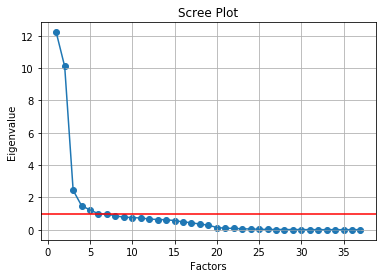

In [52]:
plt.scatter(range(1,X_train1.shape[1]+1),ev)
plt.plot(range(1,X_train1.shape[1]+1),ev)
plt.title('Scree Plot')
plt.axhline(1, color = 'r')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [53]:
ev[ev>1]

array([12.2039055 , 10.10067084,  2.44013193,  1.48172252,  1.22384523])

In [54]:
fa = FactorAnalyzer(rotation = 'varimax', n_factors = 5)
fa.fit(X_train1)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=5, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [55]:
pd.DataFrame(fa.get_factor_variance(), index = ['SS_loadings', 'Proportion Var', 'Cumulative Var'])

,0,1,2,3,4
SS_loadings,10.307698,10.114497,2.168473,1.984675,1.378506
Proportion Var,0.278586,0.273365,0.058607,0.053640,0.037257
Cumulative Var,0.278586,0.551951,0.610559,0.664198,0.701455


In [ ]:
#X_train2 해본거

In [62]:
fa = FactorAnalyzer()
fa.fit(X_train2)
ev, v = fa.get_eigenvalues()

ev[ev>1]

array([12.21484244, 10.08758448,  2.40931761,  1.45633041,  1.19053528])

In [64]:
fa = FactorAnalyzer(rotation = 'varimax', n_factors = 5)
fa.fit(X_train2)
pd.DataFrame(fa.get_factor_variance(), index = ['SS_loadings', 'Proportion Var', 'Cumulative Var'])

,0,1,2,3,4
SS_loadings,10.083730,9.119302,3.218231,2.206522,1.275131
Proportion Var,0.272533,0.246468,0.086979,0.059636,0.034463
Cumulative Var,0.272533,0.519001,0.605980,0.665616,0.700079


In [65]:
#PCA score 로 돌려보기

In [79]:
X_col = train.iloc[:, :38]
y_col = train.iloc[:, 38:]
X_col1 = test.iloc[:, :38]
y_col1 = test.iloc[:, 38:]
#풍향 cos 변환하고 모든 col

In [75]:
fa = FactorAnalyzer(rotation = 'varimax', n_factors = 6)
fa.fit(X_col)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=6, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [81]:
X_pca = pd.DataFrame(fa.fit_transform(X_col), columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6'])
X_pca

,X1,X2,X3,X4,X5,X6
0,0.143710,-2.419606,0.948195,-0.596057,0.175503,-1.107855
1,0.140785,-2.470649,0.773637,-0.566266,0.247975,-1.292932
2,0.130766,-2.505918,0.735183,-0.501713,0.285323,-1.272956
3,0.117753,-2.491041,0.685372,-0.570643,0.267810,-1.159073
4,0.112681,-2.529300,0.605285,-0.644662,0.278049,-1.248501
...,...,...,...,...,...,...
4747,-0.464961,0.267530,-1.220095,-0.142235,-0.898913,0.535556
4748,-0.464677,0.223421,-1.218172,-0.106220,-0.785139,0.525734
4749,-0.470231,0.264764,-1.460405,-0.076762,-0.724828,0.431906
4750,-0.487163,0.260603,-1.608051,-0.067508,-0.743382,0.340789


In [82]:
fa = FactorAnalyzer(rotation = 'varimax', n_factors = 6)
fa.fit(X_col1)
X_pca1 = pd.DataFrame(fa.fit_transform(X_col1), columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6'])
X_pca1

,X1,X2,X3,X4,X5,X6
0,-0.122449,-0.252263,-1.486694,-0.375054,-0.205000,-0.607302
1,-0.139580,-0.306665,-1.455191,-0.364977,-0.116668,-0.659331
2,-0.159106,-0.336754,-1.425513,-0.345974,0.132991,-0.778463
3,-0.155388,-0.263419,-1.445661,-0.362067,0.188456,-0.591127
4,-0.160992,-0.431770,-1.439163,-0.240066,-0.059611,-0.574037
...,...,...,...,...,...,...
11515,1.312984,1.261171,0.151561,-1.675148,0.688021,1.114570
11516,1.316119,1.395525,0.150597,-1.552490,0.747745,1.131161
11517,1.324599,1.445487,0.015544,-1.538565,0.668168,1.157543
11518,1.304837,1.224985,0.133874,-1.451497,0.715159,0.976265


In [83]:
x_num = 6
train= pd.concat([X_pca, y_col], axis = 1)
train_df = X_pca.copy()
test = pd.concat([X_pca1, y_col1], axis = 1)
test_df = X_pca1.copy()

In [84]:
#지정한 Y들만큼 데이터의 길이를 늘림
sequence = np.empty((0, 12, x_num))
target = np.empty((0,))

for column in y_columns :
    
    concat = pd.concat([train_df, train[column]], axis = 1)

    _sequence, _target = convert_to_timeseries(concat.head(144*30), interval = 12)

    sequence = np.vstack((sequence, _sequence))
    target = np.hstack((target, _target))

100%|████████████████████████████████████| 4308/4308 [00:02<00:00, 2117.13it/s]


In [85]:
"""
#6. test_df 생성 (x변수를 모두 사용)
"""

train_df['dummy'] = 0
test_df['dummy'] = 0

X_test, _ = convert_to_timeseries(pd.concat([train_df, test_df], axis = 0), interval=12)
X_test = X_test[-11520:, :, :]

# 만들어 두었던 dummy feature 제거
train_df.drop('dummy', axis = 1, inplace = True)
test_df.drop('dummy', axis = 1, inplace = True)

100%|███████████████████████████████████| 16260/16260 [00:21<00:00, 752.13it/s]


In [86]:
train

,X1,X2,X3,X4,X5,X6,Y00,Y01,Y02,Y03,...,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
0,0.143710,-2.419606,0.948195,-0.596057,0.175503,-1.107855,12.5,11.5,11.0,20.0,...,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN
1,0.140785,-2.470649,0.773637,-0.566266,0.247975,-1.292932,12.5,11.0,11.0,20.0,...,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN
2,0.130766,-2.505918,0.735183,-0.501713,0.285323,-1.272956,12.0,11.0,11.0,19.5,...,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN
3,0.117753,-2.491041,0.685372,-0.570643,0.267810,-1.159073,12.0,11.0,11.0,19.5,...,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN
4,0.112681,-2.529300,0.605285,-0.644662,0.278049,-1.248501,12.0,10.5,10.5,19.0,...,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,-0.464961,0.267530,-1.220095,-0.142235,-0.898913,0.535556,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4748,-0.464677,0.223421,-1.218172,-0.106220,-0.785139,0.525734,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4749,-0.470231,0.264764,-1.460405,-0.076762,-0.724828,0.431906,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4750,-0.487163,0.260603,-1.608051,-0.067508,-0.743382,0.340789,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5


In [87]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=sequence.shape[-2:]),
    tf.keras.layers.Dense(256, activation='linear'),
    tf.keras.layers.Dense(128, activation='linear'),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mse')
simple_lstm_model.summary()


# loss가 4미만으로 떨어지면 학습 종료 시키는 기능
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if(logs.get('loss') < 4):
            print('\n Loss is under 4, cancelling training')
            self.model.stop_training = True
            

callbacks = myCallback()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               69120     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 135,169
Trainable params: 135,169
Non-trainable params: 0
_________________________________________________________________


In [88]:
"""
#8. 모델 학습
"""


simple_lstm_model.fit(    
    sequence, target,
    epochs=60,
    batch_size=128,
    verbose=2,
    shuffle=False,
    callbacks = [callbacks]
)

Train on 12924 samples
Epoch 1/60
12924/12924 - 9s - loss: 158.3878
Epoch 2/60
12924/12924 - 4s - loss: 8.3384
Epoch 3/60
12924/12924 - 4s - loss: 8.5580
Epoch 4/60
12924/12924 - 5s - loss: 10.2149
Epoch 5/60
12924/12924 - 4s - loss: 8.9108
Epoch 6/60
12924/12924 - 5s - loss: 5.0978
Epoch 7/60
12924/12924 - 5s - loss: 4.0342
Epoch 8/60

 Loss is under 4, cancelling training
12924/12924 - 5s - loss: 3.9521


In [90]:
"""

#9. 마지막 3일 데이터('Y18')를 사용하여 fine-tuning 

"""


simple_lstm_model.layers[0].trainable = False
finetune_X, finetune_y = convert_to_timeseries(pd.concat([train_df.tail(432), train['Y18'].tail(432)], axis = 1), interval=12)


finetune_history = simple_lstm_model.fit(
            finetune_X, finetune_y,
            epochs=60,
            batch_size=64,
            shuffle=False,
            verbose = 2)

100%|██████████████████████████████████████| 420/420 [00:00<00:00, 1010.20it/s]


Train on 420 samples
Epoch 1/60
420/420 - 0s - loss: 2.9812
Epoch 2/60
420/420 - 0s - loss: 2.9509
Epoch 3/60
420/420 - 0s - loss: 2.9214
Epoch 4/60
420/420 - 0s - loss: 2.8924
Epoch 5/60
420/420 - 0s - loss: 2.8638
Epoch 6/60
420/420 - 0s - loss: 2.8357
Epoch 7/60
420/420 - 0s - loss: 2.8077
Epoch 8/60
420/420 - 0s - loss: 2.7802
Epoch 9/60
420/420 - 0s - loss: 2.7529
Epoch 10/60
420/420 - 0s - loss: 2.7260
Epoch 11/60
420/420 - 0s - loss: 2.6994
Epoch 12/60
420/420 - 0s - loss: 2.6731
Epoch 13/60
420/420 - 0s - loss: 2.6472
Epoch 14/60
420/420 - 0s - loss: 2.6216
Epoch 15/60
420/420 - 0s - loss: 2.5963
Epoch 16/60
420/420 - 0s - loss: 2.5712
Epoch 17/60
420/420 - 0s - loss: 2.5463
Epoch 18/60
420/420 - 0s - loss: 2.5216
Epoch 19/60
420/420 - 0s - loss: 2.4969
Epoch 20/60
420/420 - 0s - loss: 2.4722
Epoch 21/60
420/420 - 0s - loss: 2.4475
Epoch 22/60
420/420 - 0s - loss: 2.4226
Epoch 23/60
420/420 - 0s - loss: 2.3976
Epoch 24/60
420/420 - 0s - loss: 2.3723
Epoch 25/60
420/420 - 0s - l

In [91]:
#10. 결과 예측하기 
finetune_pred = simple_lstm_model.predict(X_test)


# 제출 파일 만들기
submit = pd.DataFrame({'id':range(144*33, 144*113),
              'Y18':finetune_pred.reshape(1,-1)[0]})

submit.to_csv('result1.csv', index = False)

In [ ]:
#원래 하기로 했던 wind pca

In [97]:
wind = train.loc[:, ['X13', 'X15', 'X17', 'X25', 'X35']]

In [98]:
fa = FactorAnalyzer()
fa.fit(wind)
ev, v = fa.get_eigenvalues()

ev[ev>1]

array([1.69113187, 1.09799597])

In [101]:
fa = FactorAnalyzer(rotation = 'varimax', n_factors = 2)
fa.fit(wind)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=2, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [102]:
efa_result= pd.DataFrame(fa.loadings_, index=wind.columns)

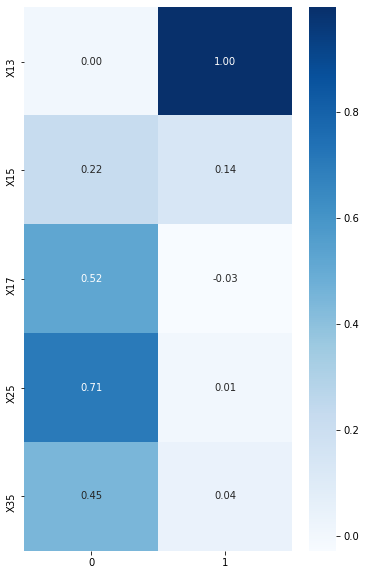

In [103]:
plt.figure(figsize=(6,10))
sns.heatmap(efa_result, cmap="Blues", annot=True, fmt='.2f')

In [ ]:
#해면 기압과 지면 기압만 합쳐서 pca

In [17]:
pressure = train.loc[:, ['X05', 'X08', 'X09', 'X23', 'X33', 'X01', 'X06', 'X22', 'X27', 'X29']]
pressure

,X05,X08,X09,X23,X33,X01,X06,X22,X27,X29
0,1009.3,1009.9,1009.8,1009.8,1010.1,988.8,989.6,1002.5,1008.7,1001.6
1,1009.3,1010.0,1009.9,1009.9,1010.1,988.9,989.6,1002.5,1008.7,1001.7
2,1009.2,1010.1,1010.1,1009.8,1010.0,989.0,989.7,1002.4,1008.6,1001.6
3,1009.2,1010.0,1010.0,1009.7,1010.1,988.9,989.6,1002.4,1008.7,1001.5
4,1009.2,1010.1,1010.0,1009.7,1010.1,988.9,989.7,1002.4,1008.7,1001.5
...,...,...,...,...,...,...,...,...,...,...
4747,1006.9,1007.5,1007.4,1007.5,1007.5,987.6,987.7,1000.4,1006.0,999.4
4748,1006.8,1007.5,1007.4,1007.5,1007.5,987.6,987.7,1000.3,1006.0,999.4
4749,1006.9,1007.4,1007.5,1007.6,1007.5,987.7,987.6,1000.4,1006.0,999.5
4750,1006.9,1007.6,1007.5,1007.6,1007.6,987.7,987.8,1000.4,1006.0,999.5


In [28]:
def check_fa(df, col_name, col_num = []):
    chi_square_value,p_value=calculate_bartlett_sphericity(train[col_num])
    kmo_all, kmo_model = calculate_kmo(train[col_num])
    print(chi_square_value, p_value, kmo_model)

In [46]:
def make_train_fa_col(df, col_name, col_num = []):
    fa = FactorAnalyzer()
    fa.fit(train[col_num])
    ev, v = fa.get_eigenvalues()
    factor_num = len(ev[ev > 1])
    
    fa = FactorAnalyzer(rotation = 'varimax', n_factors = factor_num)
    fa.fit(train[col_num])
    df[col_name] = pd.DataFrame(fa.fit_transform(train[col_num]))

In [19]:
chi_square_value,p_value=calculate_bartlett_sphericity(pressure)
print(chi_square_value, p_value)
kmo_all,kmo_model=calculate_kmo(pressure)
print(kmo_model)

271205.10758835654 0.0
0.8129025387268278


C:\Anaconda\lib\site-packages\factor_analyzer\utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


In [30]:
fa = FactorAnalyzer()
fa.fit(pressure)
ev, v = fa.get_eigenvalues()
ev[ev>1]
len(ev[ev>1])

1

In [21]:
fa = FactorAnalyzer(rotation = 'varimax', n_factors = 1)
fa.fit(pressure)
pd.DataFrame(fa.get_factor_variance(), index = ['SS_loadings', 'Proportion Var', 'Cumulative Var'])

C:\Anaconda\lib\site-packages\factor_analyzer\factor_analyzer.py:626: UserWarning: No rotation will be performed when the number of factors equals 1.
  warnings.warn('No rotation will be performed when '


,0
SS_loadings,9.923587
Proportion Var,0.992359
Cumulative Var,0.992359


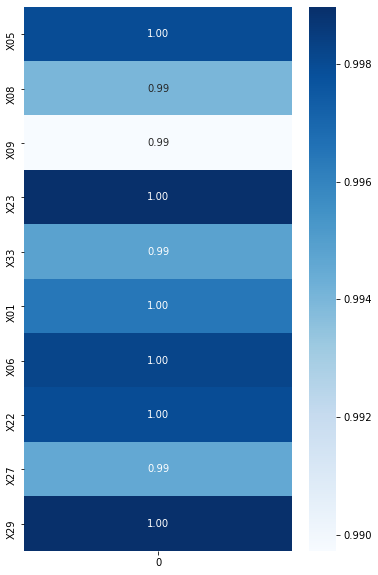

In [23]:
efa_result = pd.DataFrame(fa.loadings_, index = pressure.columns)
plt.figure(figsize=(6,10))
sns.heatmap(efa_result, cmap="Blues", annot=True, fmt='.2f')

In [ ]:
#지정한 Y들만큼 데이터의 길이를 늘림
sequence = np.empty((0, 12, x_num))
target = np.empty((0,))

for column in y_columns :
    
    concat = pd.concat([train_df, train[column]], axis = 1)

    _sequence, _target = convert_to_timeseries(concat.head(144*30), interval = 12)

    sequence = np.vstack((sequence, _sequence))
    target = np.hstack((target, _target))

# Random Forest

In [34]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

param_grid = [{'n_estimators' : np.arange(3, 5000,1), 'max_leaf_nodes' : np.arange(2,100,2)}]


grid_search = RandomizedSearchCV(forest_reg, param_grid, cv=10,     
    scoring='neg_mean_squared_error', return_train_score = True)


In [38]:
Y_mean = np.mean(train.loc[:, ['Y09', 'Y15', 'Y16', 'Y18']], axis = 1)

In [42]:
grid_search.fit(train_df, Y_mean)

grid_search.best_params_

{'n_estimators': 219, 'max_leaf_nodes': 96}

In [43]:
rnd_clf = RandomForestRegressor(n_estimators =219, max_leaf_nodes =96, n_jobs = -1)

rnd_clf.fit(train_df, Y_mean)
rnd_clf_pred = rnd_clf.predict(test_df)

rnd_clf_pred = pd.DataFrame(rnd_clf_pred)

In [44]:
rnd_clf_pred

,0
0,20.191210
1,19.975946
2,19.975946
3,19.835769
4,19.986114
...,...
11515,25.860658
11516,25.860658
11517,25.959469
11518,25.860658


In [45]:
result = pd.DataFrame()
result['id'] = range(144*33, 144*113)
result['Y18'] = rnd_clf_pred

In [46]:
result

,id,Y18
0,4752,20.191210
1,4753,19.975946
2,4754,19.975946
3,4755,19.835769
4,4756,19.986114
...,...,...
11515,16267,25.860658
11516,16268,25.860658
11517,16269,25.959469
11518,16270,25.860658


In [47]:
result.to_csv('result1.csv', index = False)

outlier 탐지

In [11]:
from sklearn.ensemble import IsolationForest

In [15]:
train_df.describe()

,X00,X07,X28,X31,X32,X11,X34
count,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000
mean,20.227904,21.658081,22.079040,19.846528,20.012984,0.161090,0.168702
std,4.707570,4.377216,4.225203,5.520259,5.271630,0.202782,0.221124
min,8.300000,11.600000,10.300000,5.300000,5.500000,0.000000,0.000000
25%,16.900000,18.400000,19.000000,16.000000,16.300000,0.000000,0.000000
50%,19.900000,21.200000,21.700000,19.400000,19.600000,0.050000,0.040000
75%,24.100000,24.825000,25.200000,24.100000,24.100000,0.300000,0.320000
max,30.900000,32.700000,33.200000,33.100000,32.900000,2.020000,3.100000


In [19]:
model=IsolationForest(n_estimators=50, max_samples='auto',max_features=1.0)
model.fit(train_df['X00'].values.reshape(-1,1))

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=50,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [20]:
outlier = pd.DataFrame()
outlier['scores'] = model.decision_function(train_df['X00'].values.reshape(-1,1))
outlier['anomaly'] = model.predict(train_df['X00'].values.reshape(-1,1))

In [42]:
train_df['X00'][1].reshape(-1,1)

array([[9.3]])

In [84]:
which = []
what = []

def find_outlier(df) :
    df1 = df.copy()
    for i in range(144*7, len(df)):
        prior_data = df.iloc[i-144*7:i]
        model.fit(prior_data.values.reshape(-1,1))
        score = model.decision_function(df[i].reshape(-1,1))
        
        if score < -0.25 :
            which.append(i)
            what.append(df[i])
            df[i] = df1[i-1]

In [85]:
for j in train_df.columns:
    find_outlier(train_df[j])

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [86]:
which

[1966,
 1970,
 3390,
 3398,
 3402,
 3407,
 3395,
 3396,
 3397,
 3399,
 3401,
 3403,
 1957,
 2899,
 3401,
 1954,
 1955,
 3179,
 3395,
 3397,
 3399,
 3403,
 3404,
 1953,
 1956,
 3398,
 3400,
 3092,
 3099,
 2819,
 3242,
 3823]

In [87]:
what

[29.8,
 30.9,
 27.8,
 28.3,
 29.3,
 28.9,
 29.1,
 29.2,
 29.5,
 29.3,
 29.6,
 29.9,
 29.9,
 15.5,
 29.8,
 29.6,
 29.9,
 12.5,
 28.9,
 29.3,
 29.6,
 29.8,
 30.1,
 29.2,
 30.0,
 29.2,
 29.2,
 0.629999999999999,
 0.6600000000000001,
 0.7100000000000009,
 0.7300000000000004,
 0.7100000000000009]

In [89]:
train_rmv = train_df.copy()
train_rmv.to_csv('train_rmv.csv')

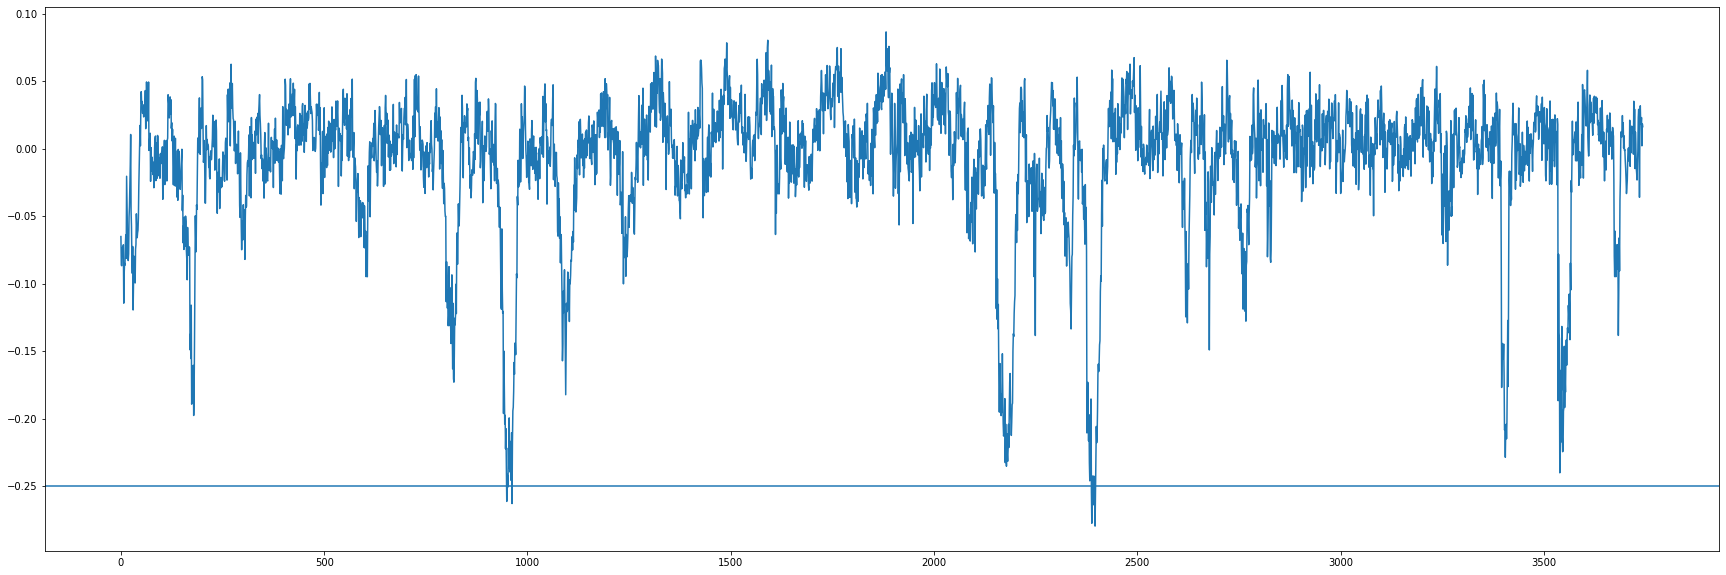

In [55]:
plt.figure(figsize = (30,10))
plt.plot(scores)
plt.axhline(-0.25)

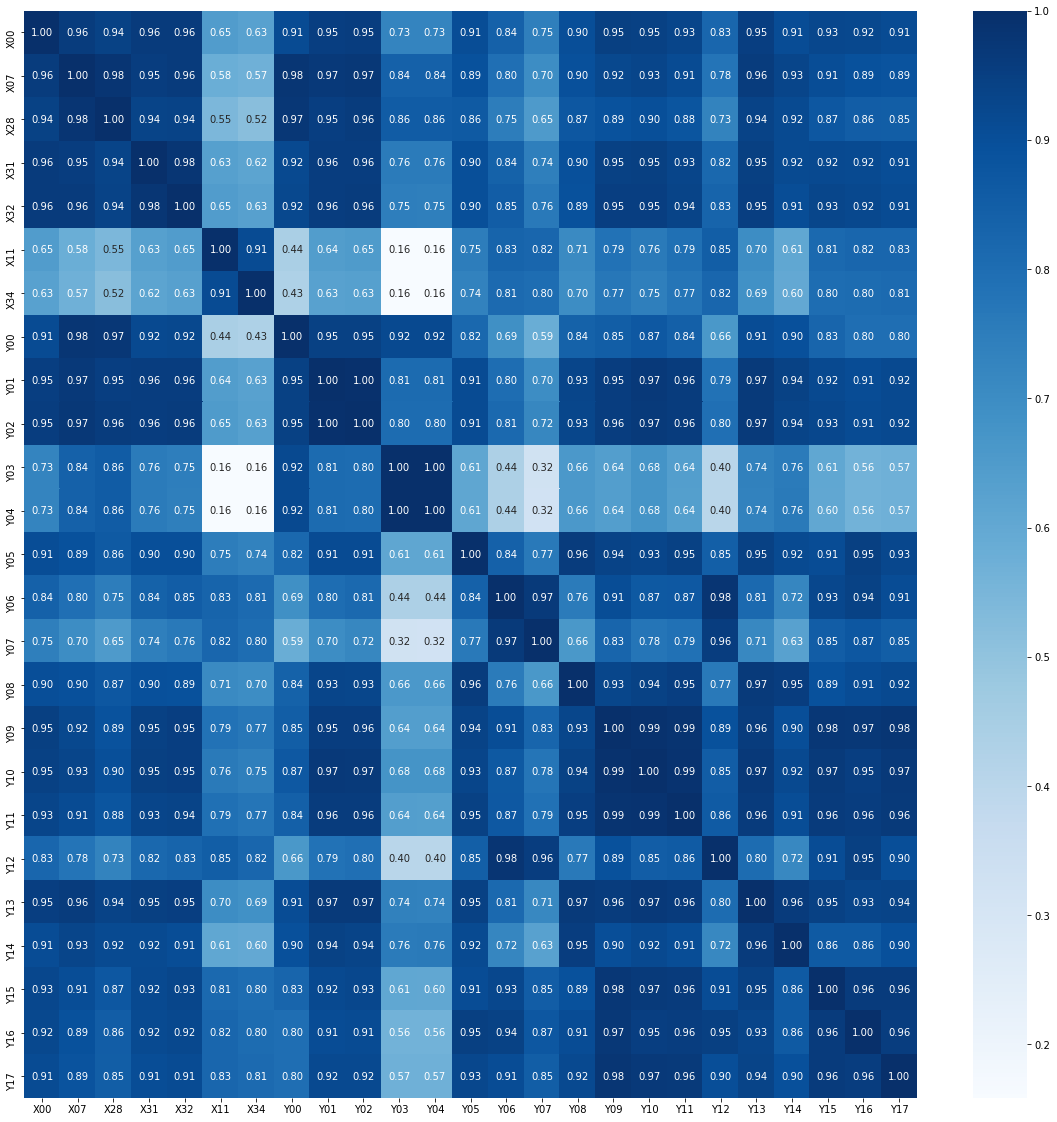

In [125]:
import seaborn as sns

dataset = pd.concat([train_df, train.iloc[:144*33, 38:-1]], axis = 1)
dataset_cor = dataset.corr()
plt.figure(figsize=(20,20))
sns.heatmap(dataset_cor, cmap="Blues", annot=True, fmt='.2f')

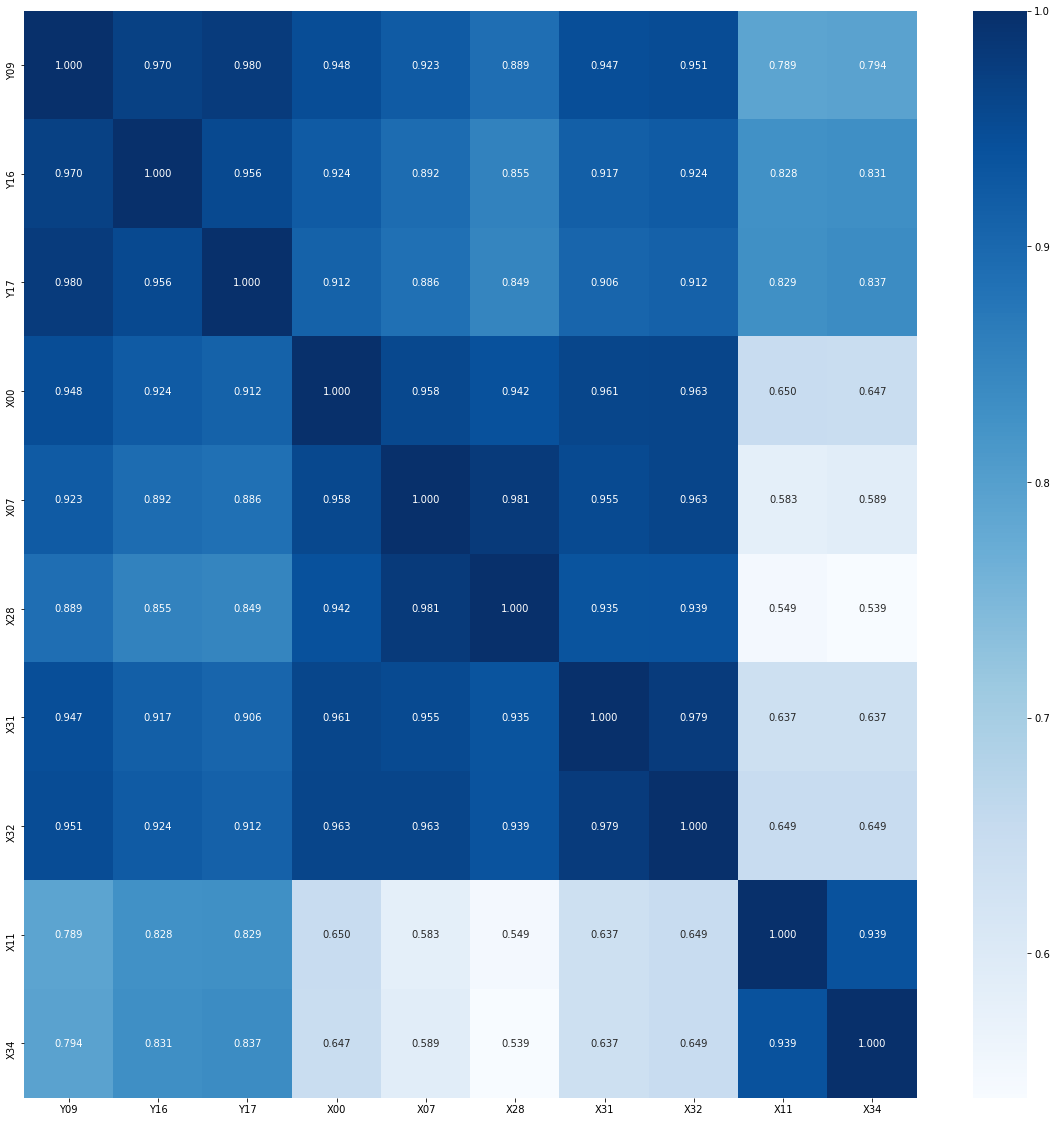

In [182]:
dataset1 = pd.concat([train.iloc[:144*33, :][['Y09', 'Y16', 'Y17']], train_df], axis =1)
dataset1_cor = dataset1.corr()
plt.figure(figsize = (20, 20))
sns.heatmap(dataset1_cor, cmap="Blues", annot=True, fmt='.3f')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

y_train = train.iloc[:144*33, :]['Y09']
y_test = train.iloc

log_rg = LogisticRegression().fit(train_df, y_train)
cross_val_score(log_rg, train_df, y_train, cv=5)
log_rg.score(test_df, y_test)
print(classification_report(y_test, log_rg.predict(X_test_scaled)))

feature_importance_lr = pd.DataFrame(zip(X.columns.values, log_rg.coef_.ravel()))
feature_importance_lr.columns = ['feature', 'coef']
feature_importance_lr.sort_values("coef", ascending=False, inplace=True)